In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [5]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

data_size = 20000
x=gen_x()
y=gen_y(x)

mi = mutual_info_regression(x.reshape(-1, 1), y.ravel())[0]
print(mi)

0.6610427398255202


In [22]:
def ma(array, policy,window_size=None, beta=None):
    x=np.zeros(len(array))
    if policy=='window':
        for i in range(0, len(array)):
            if i<window_size:
                x[i]= np.mean(array[0: i])
            else:
                x[i]= np.mean(array[i-window_size: i])
    elif policy=='weighted':
        x[0]=array[0]
        for i in range(1, len(array)):
               x[i]=x[i-1]*(1-beta)+beta*array[i]
    return x


Window policy error
0.006000639315129684


Window policy error beta=0.1
0.006373392219981952


Window policy error beta=0.01
0.004699520684984974


Window policy error beta=0.5
0.007981351231164948


Window policy error beta=0.9
0.010498650601669452




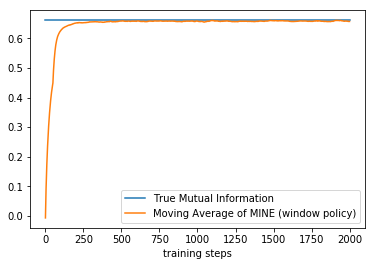

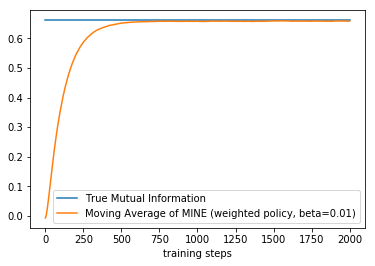

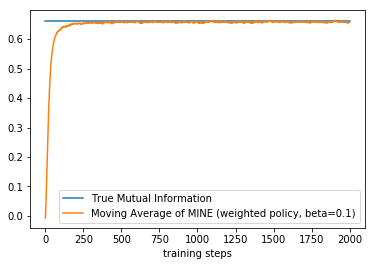

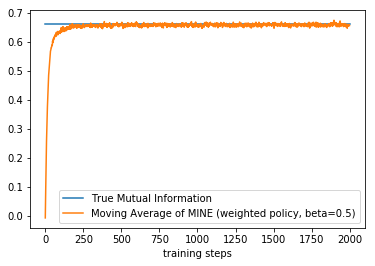

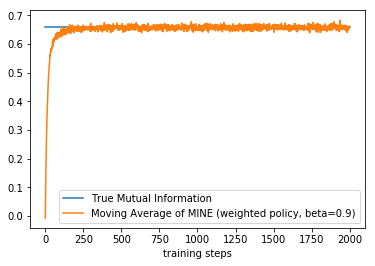

In [33]:
H=20
n_epochs = 2000
data_size = 20000

def MINE(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    
    # propagate the forward pass
    layerx = layers.linear(x_conc, H)
    layery = layers.linear(y_conc, H)
    layer2 = tf.nn.relu(layerx + layery)
    output = layers.linear(layer2, 1)
    
    # split in T_xy and T_x_y predictions
    N_samples = tf.shape(x_in)[0]
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    # compute the negative loss (maximise loss == minimise -loss)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))))
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)

    return neg_loss, opt

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, 1], name='x_in')
y_in = tf.placeholder(tf.float32, [None, 1], name='y_in')

# make the loss and optimisation graphs
neg_loss, opt = MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []
for epoch in range(n_epochs):
    
    # generate the data
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    
    # perform the training step
    feed_dict = {x_in:x_sample, y_in:y_sample}
    _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)
    
    # save the loss
    MIs.append(-neg_l)

mv_av=ma(MIs,window_size=50,policy='window')
mv_av_w1=ma(MIs, policy='weighted', beta=0.01)
mv_av_w2=ma(MIs, policy='weighted', beta=0.5)
mv_av_w3=ma(MIs, policy='weighted', beta=0.9)
mv_av_w4=ma(MIs, policy='weighted', beta=0.1)



fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av)), mv_av, label='Moving Average of MINE (window policy)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_window.png')
fig.show()

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_w1)), mv_av_w1, label='Moving Average of MINE (weighted policy, beta=0.01)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_beta_0.01 2000 epochs.png')
fig.show()

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_w4)), mv_av_w4, label='Moving Average of MINE (weighted policy, beta=0.1)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_beta_0.1.png')
fig.show()

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_w2)), mv_av_w2, label='Moving Average of MINE (weighted policy, beta=0.5)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_beta_0.5.png')
fig.show()

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av_w3)), mv_av_w3, label='Moving Average of MINE (weighted policy, beta=0.9)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_beta_0.9.png')
fig.show()


error1=(abs(mv_av[-1]-mi)/mi)*100
error2=(abs(mv_av_w1[-1]-mi)/mi)*100
error3=(abs(mv_av_w2[-1]-mi)/mi)*100
error4=(abs(mv_av_w3[-1]-mi)/mi)*100
error5=(abs(mv_av_w4[-1]-mi)/mi)*100


print('Window policy error')
print(error1)
print('\n')

print('Window policy error beta=0.1')
print(error5)
print('\n')

print('Window policy error beta=0.01')
print(error2)
print('\n')

print('Window policy error beta=0.5')
print(error3)
print('\n')

print('Window policy error beta=0.9')
print(error4)
print('\n')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE.png')
fig.show()




